> **import 필요 모듈**

데이터 불러오기 및 확인

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ast
import os
from glob import glob
from tqdm import tqdm
from dask import bag
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import top_k_categorical_accuracy
import os
from tqdm import tqdm

path = os.listdir('/kaggle/input/quickdraw-doodle-recognition/train_simplified')
path
df = pd.read_csv('/kaggle/input/quickdraw-doodle-recognition/train_simplified/'+path[0])
df

Using TensorFlow backend.


,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[92, 91, 82, 69, 64, 56, 28, 15, 6, 0, 1, 18...",4745881255411712,True,2017-03-10 13:46:31.635970,sleeping bag
1,US,"[[[52, 22, 12, 5, 1, 0, 5, 26, 149, 184, 230, ...",4859794726846464,False,2017-03-04 17:08:46.745630,sleeping bag
2,AU,"[[[4, 3, 11, 22, 38, 63, 251, 255, 251, 252, 2...",4573190200229888,True,2017-03-17 06:36:27.083520,sleeping bag
3,BR,"[[[4, 183, 191, 202, 204, 201, 189, 10, 3, 0, ...",5103637015560192,True,2017-03-26 20:34:57.242880,sleeping bag
4,US,"[[[64, 67], [57, 114]], [[64, 91, 163], [57, 6...",6037379364159488,False,2017-03-01 01:39:06.642580,sleeping bag
...,...,...,...,...,...,...
119686,US,"[[[11, 35, 107, 164, 198, 190, 188, 192, 182, ...",5773585861836800,True,2017-03-12 02:27:03.268360,sleeping bag
119687,US,"[[[4, 29, 56, 136, 171, 185, 238, 254, 255, 24...",4697827487776768,True,2017-01-26 22:46:07.644720,sleeping bag
119688,FI,"[[[230, 196, 174, 123, 23, 10], [18, 16, 6, 7,...",5566971963768832,True,2017-03-06 10:29:33.236430,sleeping bag
119689,US,"[[[6, 4, 9, 5, 7, 1, 0, 3, 8, 20, 52, 75, 81, ...",6472940805685248,True,2017-03-20 12:35:23.909920,sleeping bag


open_cv를 이용 이미지 그려주기
word에 띄어쓰기  '_' 로변경하기 
tmp설정후 이미지확인

[[0.   0.   0.25 ... 0.   0.   0.  ]
 [1.   1.   0.   ... 0.   0.   0.  ]
 [1.   0.   0.5  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   1.   1.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


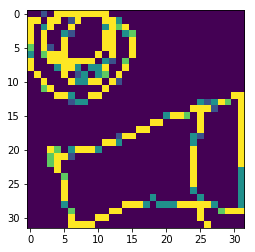

In [2]:
def stroke_to_img(strokes): 
    img=np.zeros((256,256))
    for each in ast.literal_eval(strokes):
        for i in range(len(each[0])-1):
            cv2.line(img,(each[0][i],each[1][i]),(each[0][i+1],each[1][i+1]),255,5)
    img=cv2.resize(img,(32,32))
    img=img/255
    return img

tmp = df['drawing'][8]
df['word']= df['word'].replace(' ','_',regex = True)
img = np.array(stroke_to_img(tmp))
plt.imshow(img)
print(img)

In [3]:
rd=np.random.randint(340)#340까지의 수 중에 난수생성
nums2names={i : v[:-4].replace(' ','_') for i , v in enumerate(path)}#불러온 데이터에 index 번호붙이기
ranclass=nums2names[rd]# 340까지의 수중에 랜덤으로 불러오기  
ranclass=ranclass.replace('_',' ')# 분류 제목을 _을 ' '로 바꿔주기
rdpath='/kaggle/input/quickdraw-doodle-recognition/train_simplified/'+ranclass+'.csv' #랜덤으로 하나의 클래스 경로설정
one=pd.read_csv(rdpath,usecols=['drawing','recognized','word'],nrows=10) #10개 행의 drawing recognized word 불러오기
one=one[one.recognized==True].head(2)#그림 중 true인것 2개만불러오기
name=one['word'].head(1)#one의 첫번째 word 
strk=one['drawing']# one 의 drawing #2개
pic=[]
for s in strk:
    pic.append(stroke_to_img(s))
    #pic에 그려준것 추가하기
name=name.values


데이터 추가 하기 

In [4]:
train_grand=[]
num_class = 340
per_class=2000

In [5]:
class_paths = glob('/kaggle/input/quickdraw-doodle-recognition/train_simplified/*.csv')
for i , c in enumerate(tqdm(class_paths[0:num_class])): 
    train=pd.read_csv(c,usecols=['drawing','recognized'],nrows=per_class*2)
    train=train[train.recognized==True].head(per_class)
    imagebag=bag.from_sequence(train.drawing.values).map(stroke_to_img)
    train_array=np.array(imagebag.compute())#unmpy 형식 
    train_array=np.reshape(train_array,(per_class,-1))  #2000  -1로 reshpae로 행렬 형식 변경 그림형식    
    label_array=np.full((train.shape[0],1),i)# label 붙여주기 , train.shape[0] = 2000
    train_array=np.concatenate((label_array,train_array),axis=1)
    train_grand.append(train_array)
del train_array
del label_array


100%|██████████| 340/340 [09:26<00:00,  1.67s/it]


In [6]:
train_grand=np.array([train_grand.pop() for i in np.arange(num_class)]) #데이터 세팅

In [7]:
height = 32
width = 32

In [8]:
train_grand=train_grand.reshape((-1,(height*width+1))) #32*32로 배열 변경
print(train_grand)

[[339.   0.   0. ...   0.   0.   0.]
 [339.   0.   0. ...   0.   0.   0.]
 [339.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


setting to ( training set :  test set ) =  ( 9 : 1  )

In [9]:
specific = 0.1 
sequence_length = 50
cut = int(specific * train_grand.shape[0])
print(cut)

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cut: , 0], train_grand[cut: , 1:]
y_val, X_val = train_grand[0:cut, 0], train_grand[0:cut, 1:]

# del train_grand

x_train=X_train.reshape(X_train.shape[0],height,width,1)
x_val=X_val.reshape(X_val.shape[0],height,width,1)

print(y_train.shape, "\n",
      x_train.shape, "\n",
      y_val.shape, "\n",
      x_val.shape)



68000
(612000,) 
 (612000, 32, 32, 1) 
 (68000,) 
 (68000, 32, 32, 1)


In [10]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(height,width,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class,activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)        

In [11]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [12]:
reduceLROnPlat=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,
                                 verbose=1,mode='auto',min_delta=0.005,
                                 cooldown=5,min_lr=0.0001)

callbacks=[reduceLROnPlat]

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',
              metrics=['accuracy',top_3_accuracy])

history=model.fit(x=x_train,y=y_train,batch_size=32,epochs=20,
                  validation_data=(x_val,y_val),callbacks=callbacks,verbose=1)

Train on 612000 samples, validate on 68000 samples
Epoch 1/20
612000/612000 [==============================] - 133s 218us/step - loss: 2.1670 - accuracy: 0.4675 - top_3_accuracy: 0.0085 - val_loss: 1.5490 - val_accuracy: 0.5919 - val_top_3_accuracy: 0.0094
Epoch 2/20
612000/612000 [==============================] - 130s 212us/step - loss: 1.5196 - accuracy: 0.5961 - top_3_accuracy: 0.0095 - val_loss: 1.4108 - val_accuracy: 0.6236 - val_top_3_accuracy: 0.0157
Epoch 3/20
612000/612000 [==============================] - 128s 210us/step - loss: 1.3920 - accuracy: 0.6234 - top_3_accuracy: 0.0095 - val_loss: 1.3241 - val_accuracy: 0.6465 - val_top_3_accuracy: 0.0085
Epoch 4/20
612000/612000 [==============================] - 128s 208us/step - loss: 1.3287 - accuracy: 0.6382 - top_3_accuracy: 0.0095 - val_loss: 1.2984 - val_accuracy: 0.6526 - val_top_3_accuracy: 0.0077
Epoch 5/20
456448/612000 [=====================>........] - ETA: 31s - loss: 0.9065 - accuracy: 0.7374 - top_3_accuracy: 0.00

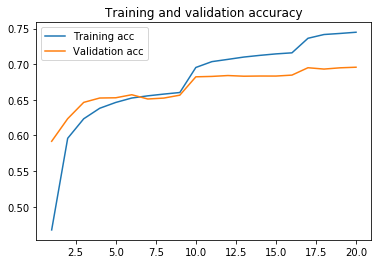

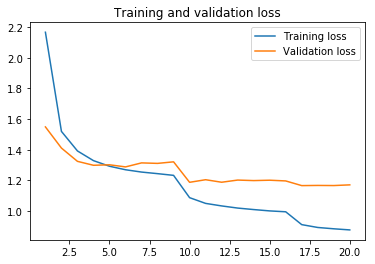

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,label='Training acc')
plt.plot(epochs,val_acc,label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
list=[]
reader=pd.read_csv('/kaggle/input/quickdraw-doodle-recognition/test_simplified.csv',index_col=['key_id'],chunksize=2048)
for chunk in tqdm(reader,total=55):
    imagebag=bag.from_sequence(chunk.drawing.values).map(stroke_to_img)
    testarray=np.array(imagebag.compute())
    testarray=np.reshape(testarray,(testarray.shape[0],height,width,1))
    testpreds=model.predict(testarray,verbose=0)
    s=np.argsort(-testpreds)[:,0:3]
    list.append(s)
array=np.concatenate(list)
pred_df=pd.DataFrame({'first': array[:,0],'second':array[:,1],'third':array[:,2]})
pred_df=pred_df.replace(nums2names)
pred_df['words']=pred_df['first']+' '+pred_df['second']+' '+pred_df['third']

sub=pd.read_csv('/kaggle/input/quickdraw-doodle-recognition/sample_submission.csv',index_col=['key_id'])
sub['word']=pred_df.words.values
sub.to_csv('result_of_mission.csv')

100%|██████████| 55/55 [02:16<00:00,  2.49s/it]


In [15]:
sub.head()

,word
key_id,
9000003627287624,radio stereo cooler
9000010688666847,hockey_puck pool bottlecap
9000023642890129,The_Great_Wall_of_China castle camel
9000038588854897,mountain pliers roller_coaster
9000052667981386,fireplace campfire leaf
